Copyright 2018 Xanadu Quantum Technologies Inc.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.


strawberryfields==0.10
tensorflow==1.3



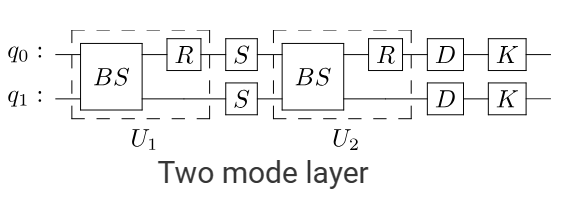

## Generando los datos

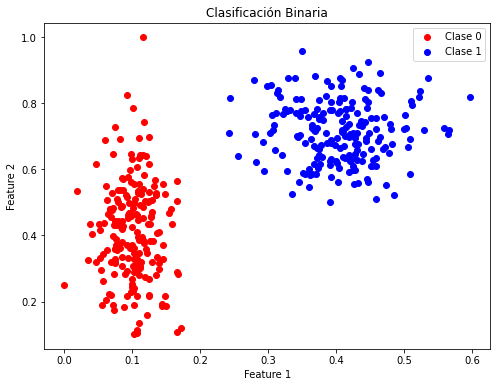

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Generar datos aleatorios para dos clases
np.random.seed(42)
num_samples_per_class = 200

# Clase 0 con media [1, 2] y desviación estándar [0.1, 0.5]
class_0 = np.random.normal(loc=[1, 2], scale=[0.1, 0.5], size=(num_samples_per_class, 2))

# Clase 1 con media [2, 3] y desviación estándar [0.2, 0.3]
class_1 = np.random.normal(loc=[2, 3], scale=[0.2, 0.3], size=(num_samples_per_class, 2))


# Crear el array con los datos
data = np.vstack([class_0, class_1])
labels = np.array([0] * num_samples_per_class + [1] * num_samples_per_class)

# Normalizar los datos 
data= (data - data.min()) / (data.max() - data.min())

datai = np.hstack((data, labels[:, None]))
data_points=len(data)


# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(datai[labels == 0][:, 0], datai[labels == 0][:, 1], c='red', label='Clase 0')
plt.scatter(datai[labels == 1][:, 0], datai[labels == 1][:, 1], c='blue', label='Clase 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Clasificación Binaria')
plt.show()


## Otra manera

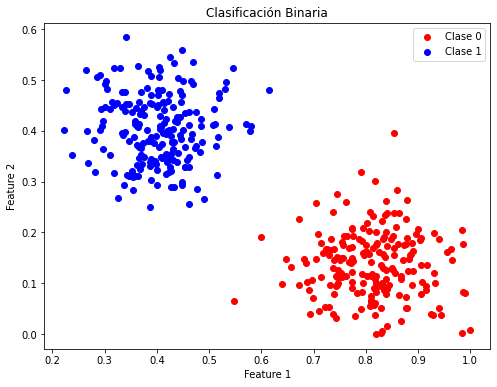

In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

np.random.seed(42)
num_samples_per_class = 200

# Clase 0 con media [1, 2] y desviación estándar [0.1, 0.5]
class_0 = np.random.normal(loc=[5, 0], scale=[0.6, 0.5], size=(num_samples_per_class, 2))

# Clase 1 con media [2, 3] y desviación estándar [0.2, 0.3]
class_1 = np.random.normal(loc=[2, 2], scale=[0.5, 0.5], size=(num_samples_per_class, 2))

# Crear el array con los datos
data = np.vstack([class_0, class_1])
labels = np.array([0] * num_samples_per_class + [1] * num_samples_per_class)

# Normalizar los datos en el rango [0, 1]
data= (data - data.min()) / (data.max() - data.min())

datao = np.hstack((data, labels[:, None]))


# Graficar los datos
plt.figure(figsize=(8, 6))
plt.scatter(datao[labels == 0][:, 0], datao[labels == 0][:, 1], c='red', label='Clase 0')
plt.scatter(datao[labels == 1][:, 0], datao[labels == 1][:, 1], c='blue', label='Clase 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Clasificación Binaria')
plt.show()

d=datao[0]

## Hiperparametros

In [3]:
import os
import tensorflow as tf
import strawberryfields as sf
from strawberryfields.ops import Dgate, BSgate, Kgate, Sgate, Rgate
import sys

# Two modes required: one for "genuine" transactions and one for "fradulent"
mode_number = 2
# Number of photonic quantum layers
depth = 5
# Fock basis truncation
cutoff = 7
# Number of batches in optimization
reps = 1000
# Label for simulation
simulation_label = 1
# Number of batches to use in the optimization
batch_size = 10
# Random initialization of gate parameters
sdev_photon = 0.1
sdev = 1
# Variable clipping values
disp_clip = 5
sq_clip = 5
kerr_clip = 1
# If loading from checkpoint, previous batch number reached
ckpt_val = 0
# Number of repetitions between each output to TensorBoard
tb_reps = 100
# Number of repetitions between each model save
savr_reps = 1000
model_string = str(simulation_label)
# Target location of output
folder_locator = 'outputs/'
# Locations of TensorBoard and model save outputs
board_string = folder_locator + 'tensorboard/' + model_string + '/'
checkpoint_string = folder_locator + 'models/' + model_string + '/'
data_points=len(data)

C:\ProgramData\anaconda3\envs\tensorflow1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\anaconda3\envs\tensorflow1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\anaconda3\envs\tensorflow1.3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\anaconda3\envs\tensorflow1.3\lib\s

## Parametros a entrenar de la QNN

In [4]:
# neuronas input
input_neurons = 2
# neuronas output
output_neurons = 2

# Defining classical network parameters
input_classical_layer = tf.placeholder(tf.float32, shape=[batch_size, input_neurons])
output_layer=input_classical_layer

# Numero de beamspliters en el interferometro
num_bs = int(1.0 * mode_number * (mode_number - 1) / 2)

#inicializacion aleatoria de las variables
with tf.name_scope('variables'):
    bs_variables = tf.Variable(tf.random_normal(shape=[depth, num_bs, 2, 2]
                                                , stddev=sdev))
    phase_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number, 2], stddev=sdev))

    sq_magnitude_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number]
                                                          , stddev=sdev_photon))
    sq_phase_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number]
                                                      , stddev=sdev))
    disp_magnitude_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number]
                                                            , stddev=sdev_photon))
    disp_phase_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number]
                                                        , stddev=sdev))
    kerr_variables = tf.Variable(tf.random_normal(shape=[depth, mode_number], stddev=sdev_photon))

parameters = [bs_variables,phase_variables, sq_magnitude_variables, sq_phase_variables,disp_magnitude_variables,disp_phase_variables, kerr_variables]

## Circuito cuantico

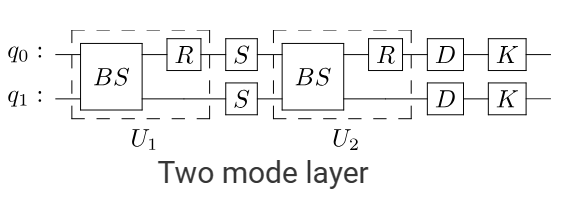

In [5]:
#Las caracteristicas entran al circuito cuantico a travez de compuertas de desplazamiento usando las neuronas clasicas
def input_qnn_layer():
    with tf.name_scope('inputlayer'):
        Dgate(output_layer[:, 0]) | q[0]
        Dgate(output_layer[:, 1]) | q[1]

# Define n capaz de la QNN con los parametros de tensorflow
def qnn_layer(layer_number):
    with tf.name_scope('layer_{}'.format(layer_number)):
        BSgate(bs_variables[layer_number, 0, 0, 0], bs_variables[layer_number, 0, 0, 1]) | (q[0], q[1])

        for i in range(mode_number):
            Rgate(phase_variables[layer_number, i, 0]) | q[i]

        for i in range(mode_number):
            Sgate(sq_magnitude_variables[layer_number, i], sq_phase_variables[layer_number, i]) | q[i]

        BSgate(bs_variables[layer_number, 0, 1, 0], bs_variables[layer_number, 0, 1, 1]) | (q[0], q[1])

        for i in range(mode_number):
            Rgate(phase_variables[layer_number, i, 1]) | q[i]

        for i in range(mode_number):
            Dgate(disp_magnitude_variables[layer_number, i], disp_phase_variables[layer_number, i]) | q[i]

        for i in range(mode_number):
            Kgate(kerr_variables[layer_number, i]) | q[i]

eng, q = sf.Engine(mode_number)

# construccion del circuito
with eng:
    input_qnn_layer()
    for i in range(depth):
        qnn_layer(i)

# Corre el circuito
state = eng.run("tf", cutoff_dim=cutoff, eval=False, batch_size=batch_size)
# Estado
ket = state.ket()

## Función de costo 
Se quiere que el modo cuántico 0 diga que el dato pertenece a la etiqueta 0 cuando el estado de fock I1> es altamente probable.

In [6]:
# para usar one-hot classification. [0, 1] para etiqueta 1, [1,0] para etiqueta 0
classification = tf.placeholder(shape=[batch_size, 2], dtype=tf.int32)

func_to_minimise = 0

# Funcion a minimizar, 
for i in range(batch_size):
    # parobabilidad de etiquetado de los datos usando el primer estado I1>
    prob = tf.abs(ket[i, classification[i, 0], classification[i, 1]]) ** 2
    func_to_minimise += (1.0 / batch_size) * (prob - 1) ** 2

# Funcion de costo
cost_func = func_to_minimise
tf.summary.scalar('Cost', cost_func)

# optimizador
optimiser = tf.train.AdamOptimizer()
training = optimiser.minimize(cost_func)

# Saver/Loader for outputting model
saver = tf.train.Saver(parameters)

session = tf.Session()
session.run(tf.global_variables_initializer())

# Load previous model if non-zero ckpt_val is specified
if ckpt_val != 0:
    saver.restore(session, checkpoint_string + 'sess.ckpt-' + str(ckpt_val))

# TensorBoard writer
writer = tf.summary.FileWriter(board_string)
merge = tf.summary.merge_all()

counter = ckpt_val

# Tracks optimum value found (set high so first iteration encodes value)
opt_val = 1e20
# Batch number in which optimum value occurs
opt_position = 0
# Flag to detect if new optimum occured in last batch
new_opt = False


## Entrenamiento 


In [7]:
while counter <= reps:
    np.random.shuffle(data)

    # separar por lotes
    split_data = np.split(data, data_points / batch_size)

    for batch in split_data:
        if counter > reps:
            break

        # Input data 
        data_input = batch[:,:-1]
        # Data clases
        classes = batch[:, -1]

        # volver las clases a one hot
        one_hot_input = np.zeros((batch_size, 2))

        for i in range(batch_size):
            #si pertenece a la etiqueta 1, es mas probable el estado I1>
            if int(classes[i]) == 0:
                one_hot_input[i] = [1, 0]
            else:
                one_hot_input[i] = [0, 1]

        # Output to TensorBoard
        if counter % tb_reps == 0:
            [summary, training_run, func_to_minimise_run] = session.run([merge, training, func_to_minimise],
                                                                        feed_dict={
                                                                            input_classical_layer:
                                                                                data_input,
                                                                            classification: one_hot_input})
            writer.add_summary(summary, counter)

        else:
            # inicia el entrenamiento
            [training_run, func_to_minimise_run] = session.run([training, func_to_minimise], feed_dict={
                input_classical_layer: data_input, classification: one_hot_input})

        # Asegura que la función de costo se comporte bien
        if np.isnan(func_to_minimise_run):
            compute_grads = session.run(optimiser.compute_gradients(cost_func),
                                        feed_dict={input_classical_layer: data_input,
                                                   classification: one_hot_input})
            if not os.path.exists(checkpoint_string):
                os.makedirs(checkpoint_string)
            # If cost function becomes NaN, output value of gradients for investigation
            np.save(checkpoint_string + 'NaN.npy', compute_grads)
            print('NaNs outputted - leaving at step ' + str(counter))
            raise SystemExit

        # Prueba para ver si se encuentra un nuevo óptimo en el lote actual
        if func_to_minimise_run < opt_val:
            opt_val = func_to_minimise_run
            opt_position = counter
            new_opt = True

        # Guarde el modelo cada número fijo de lotes, siempre que se haya producido un nuevo valor óptimo
        if (counter % savr_reps == 0) and (i != 0) and new_opt and (not np.isnan(func_to_minimise_run)):
            if not os.path.exists(checkpoint_string):
                os.makedirs(checkpoint_string)
            saver.save(session, checkpoint_string + 'sess.ckpt', global_step=counter)
            # Saves position of optimum and corresponding value of cost function
            np.savetxt(checkpoint_string + 'optimum.txt', [opt_position, opt_val])
        counter += 1
        
    print("loss at {} batch {}".format(counter,func_to_minimise_run))  

loss at 40 batch 0.5192123651504517
loss at 80 batch 0.43706899881362915
loss at 120 batch 0.34029561281204224
loss at 160 batch 0.3012145757675171
loss at 200 batch 0.2805144190788269
loss at 240 batch 0.2520468831062317
loss at 280 batch 0.2368384450674057
loss at 320 batch 0.22670792043209076
loss at 360 batch 0.2191157191991806
loss at 400 batch 0.21972906589508057
loss at 440 batch 0.19402191042900085
loss at 480 batch 0.19277739524841309
loss at 520 batch 0.18627344071865082
loss at 560 batch 0.1793481409549713
loss at 600 batch 0.1699836403131485
loss at 640 batch 0.15858636796474457
loss at 680 batch 0.15035215020179749
loss at 720 batch 0.16070376336574554
loss at 760 batch 0.1544869989156723
loss at 800 batch 0.1414061188697815
loss at 840 batch 0.14522524178028107
loss at 880 batch 0.1450757533311844
loss at 920 batch 0.14579682052135468
loss at 960 batch 0.1467972695827484
loss at 1000 batch 0.14366140961647034
loss at 1001 batch 0.13133011758327484


## Predicciones 

In [8]:
state = eng.run("tf", cutoff_dim=cutoff, eval=False, batch_size=batch_size)
ket = state.ket()

prob = []
for i in range(batch_size):
    #guarda las probabilidades
    prob.append([tf.abs(ket[i, 1, 0]) ** 2, tf.abs(ket[i, 0, 1]) ** 2])

#separar en batches
data_split = np.split(data, data_points / batch_size)

pro=[]
act=[]
for batch in data_split:
    # Input data 
    data_input = batch[:, :-1]
    # Data classes
    classes = batch[:, -1]
     
    prob_run = session.run(prob, feed_dict={input_classical_layer: data_input})

    for i in range(batch_size):
        p = prob_run[i]
        # normalizar
        p = p / np.sum(p)
        pro.append(p)
        
        #Guarda clases reales
        actual_class = classes[i]
        act.append(actual_class)


## Normalización y comparación
Se pueden comparar las etiquetas hechas por QNN con las clases

In [9]:
probabilities_normalized = (pro - np.min(pro)) / (np.max(pro) - np.min(pro))

## Etiqueta real:
Primeros 10 datos

In [10]:
act[0:10]

[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

## Etiqueta predicha
primeros 10 datos

In [11]:
probabilities_normalized[0:10,-1]

array([0.97797596, 0.16936213, 0.18514179, 0.31427047, 0.84594774,
       0.22476825, 0.1307232 , 0.19687176, 0.26403734, 0.25650942],
      dtype=float32)

## Calculo de probabilidades 
Funcion para calcular la probabilidad por lotes

In [12]:
def probablidad(data):
    state = eng.run("tf", cutoff_dim=cutoff, eval=False, batch_size=batch_size)
    ket = state.ket()

    prob = []
    for i in range(batch_size):
        prob.append([tf.abs(ket[i, 1, 0]) ** 2, tf.abs(ket[i, 0, 1]) ** 2])
        
    pro=[]
    prob_run = session.run(prob, feed_dict={input_classical_layer: data})

    for i in range(batch_size):
        p = prob_run[i]
        p = p / np.sum(p)
        pro.append(p)
    pro=np.array(pro)
    proba1=pro[:,-1]
    
    return proba1
        

prueba:

In [14]:
data=[[0.4, 0.4],
       [0.47, 0.5],
       [0.8, 0.1],
       [0.9, 0.2],
       [0.08527302, 0.49082001],
       [0.11499739, 0.38609367],
       [0.11964205, 0.64163867],
       [0.09251256, 0.37134627],
       [0.14829999, 0.52541088],
       [0.08527302, 0.49082001]]
probablidad(data)

array([0.69645035, 0.6785165 , 0.3232278 , 0.3135209 , 0.8945652 ,
       0.8644727 , 0.8965646 , 0.87311715, 0.8699233 , 0.8945652 ],
      dtype=float32)

## Gráfico

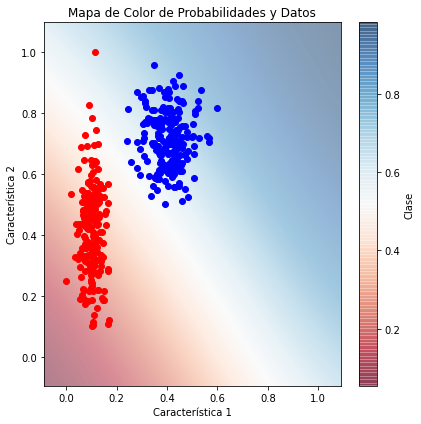

In [25]:
# Datos de ejemplo
np.random.seed(0)
X_data = np.random.rand(100, 2)  # Valores entre 0 y 1
y_data = (X_data[:, 0] + X_data[:, 1] > 0).astype(int)

# Crear una malla de puntos para graficar el mapa de color
x_min, x_max = X_data[:, 0].min() - 0.1, X_data[:, 0].max() + 0.1
y_min, y_max = X_data[:, 1].min() - 0.1, X_data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
X_grid = np.c_[xx.ravel(), yy.ravel()]
data_points = len(X_grid)



probabilities=[]
split_data = np.split(X_grid, data_points / batch_size)
for batch in split_data:
    prob_class_1 = probablidad(batch)
    probabilities.append(prob_class_1)
    
    
plt.figure(figsize=(6, 6))

probabilities=np.array(probabilities)
#Graficar el mapa de color de las probabilidades
plt.imshow(probabilities.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max), origin='lower',
           cmap='RdBu', alpha=0.5, aspect='auto')
plt.colorbar(label='Clase')
# Graficar los datos de clases 0 y 1 encima del mapa de color
plt.scatter(datai[labels == 0][:, 0], datai[labels == 0][:, 1], c='red', label='Clase 0')
plt.scatter(datai[labels == 1][:, 0], datai[labels == 1][:, 1], c='blue', label='Clase 1')
plt.title('Mapa de Color de Probabilidades y Datos')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')


plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


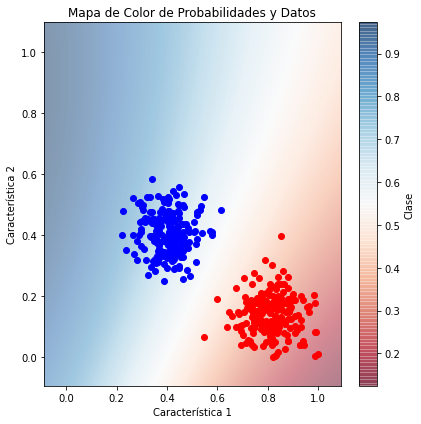

In [18]:
# Datos de ejemplo
np.random.seed(0)
X_data = np.random.rand(100, 2)  # Valores entre 0 y 1
y_data = (X_data[:, 0] + X_data[:, 1] > 0).astype(int)

# Crear una malla de puntos para graficar el mapa de color
x_min, x_max = X_data[:, 0].min() - 0.1, X_data[:, 0].max() + 0.1
y_min, y_max = X_data[:, 1].min() - 0.1, X_data[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))
X_grid = np.c_[xx.ravel(), yy.ravel()]
data_points = len(X_grid)



probabilities=[]
split_data = np.split(X_grid, data_points / batch_size)
for batch in split_data:
    prob_class_1 = probablidad(batch)
    probabilities.append(prob_class_1)
    
    
plt.figure(figsize=(6, 6))

probabilities=np.array(probabilities)
#Graficar el mapa de color de las probabilidades
plt.imshow(probabilities.reshape(xx.shape), extent=(x_min, x_max, y_min, y_max), origin='lower',
           cmap='RdBu', alpha=0.5, aspect='auto')
plt.colorbar(label='Clase')
# Graficar los datos de clases 0 y 1 encima del mapa de color
plt.scatter(datao[labels == 0][:, 0], datao[labels == 0][:, 1], c='red', label='Clase 0')
plt.scatter(datao[labels == 1][:, 0], datao[labels == 1][:, 1], c='blue', label='Clase 1')
plt.title('Mapa de Color de Probabilidades y Datos')
plt.xlabel('Característica 1')
plt.ylabel('Característica 2')


plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()
